In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
import numpy as np

import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import sys

sys.path.append('..')
from utils import BrainGraphDataset, project_root
from models import VAE
from torch.utils.data import ConcatDataset

cpu


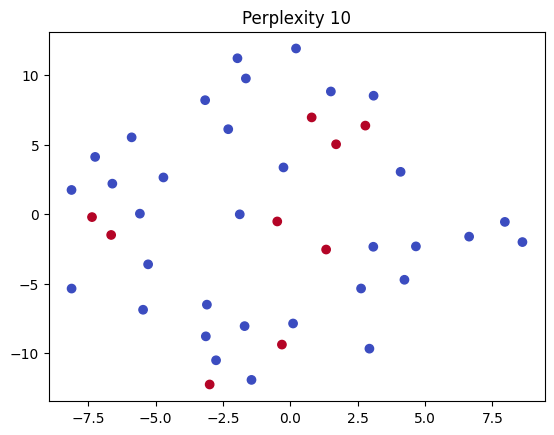

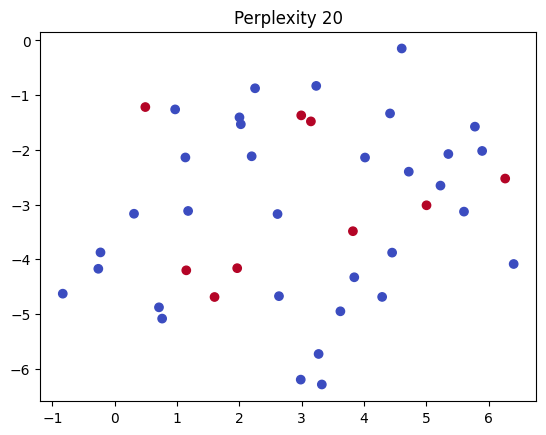

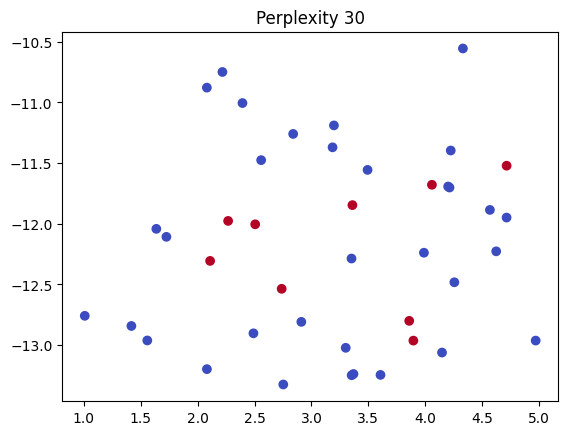

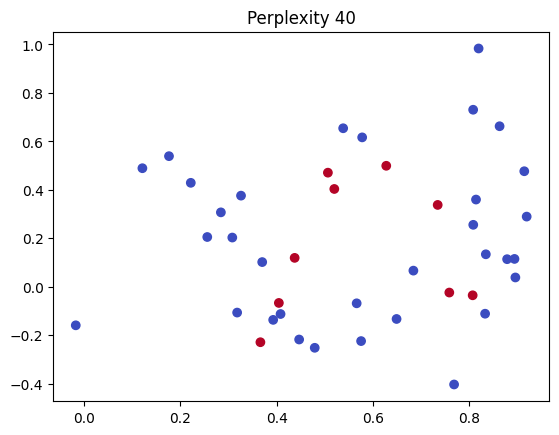

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

root = project_root()

hidden_dim = 128
latent_dim = 64
input_dim = 4950

annotations = 'annotations.csv'
dataroot = 'fc_matrices/psilo_schaefer_before/'
dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='upper_triangular')
    
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size =  num_samples - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
val_dataset = ConcatDataset([val_dataset, test_dataset])

train_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

model = VAE(input_dim, [hidden_dim] * 2, latent_dim).to(device)

model.load_state_dict(torch.load(os.path.join(root, 'vae_weights/vae_dropout_psilo_schaefer_before_0.pt'), map_location=device))

psilo_zs = []
hcp_zs = []

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        _, z, _, _ = model(data.view(-1, input_dim))
        psilo_zs.append(z)
    
    for batch_idx, (data, _) in enumerate(val_loader):
        _, z, _, _ = model(data.view(-1, input_dim))
        hcp_zs.append(z)


psilo_zs = torch.cat(psilo_zs, dim=0)
hcp_zs = torch.cat(hcp_zs, dim=0)
        
# Concatenate the encoded representations and create labels
x = torch.cat((psilo_zs, hcp_zs), dim=0)
labels = torch.cat((torch.zeros(psilo_zs.shape[0]), torch.ones(hcp_zs.shape[0])), dim=0)

from sklearn.manifold import TSNE

for per in [10,20, 30, 40]:
    # Use t-SNE to reduce the dimensionality of the encoded representations
    tsne = TSNE(n_components=2, perplexity=per, n_iter=1000)
    x_tsne = tsne.fit_transform(x)

    # Plot the t-SNE embeddings
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
    plt.title(f'Perplexity {per}')
    plt.savefig(f'tsne_{per}.png', bbox_inches='tight')
    plt.show()